# Power Spectral Density (PSD) and Instrument Self Noise

## License Information

This file is part of _hvsrpy_, a Python package for horizontal-to-vertical spectral ratio processing.

    Copyright (C) 2019-2024 Joseph P. Vantassel (joseph.p.vantassel@gmail.com)

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https: //www.gnu.org/licenses/>.
    
## About _hvsrpy_

_hvsrpy_ is an open-source Python package for performing horizontal-to-vertical spectral ratio (HVSR) processing of microtremor and earthquake recordings. _hvsrpy_ was developed by [Jospeh P. Vantassel](https://www.jpvantassel.com/) with contributions from Dana M. Brannon under the supervision of Professor Brady R. Cox at The University of Texas at Austin. _hvsrpy_ continues to be developed and maintained by [Joseph P. Vantassel and his research group at Virginia Tech](https://geoimaging-research.org/).

## Citation

If you use _hvsrpy_ in your research or consulting, we ask you please cite the following:

>Joseph Vantassel. (2020). jpvantassel/hvsrpy: latest (Concept). Zenodo.
[http://doi.org/10.5281/zenodo.3666956](http://doi.org/10.5281/zenodo.3666956)

_Note: For software, version specific citations should be preferred to
general concept citations, such as that listed above. To generate a version
specific citation for hvsrpy, please use the citation tool on the hvsrpy
[archive](http://doi.org/10.5281/zenodo.3666956)._

## About this notebook

This notebook illustrates how _hvsrpy_ can be used for computing the power spectral density (PSD) using the method proposed by Welch (1967).

>Welch, P., (1967). The use of fast Fourier transform for the estimation of power spectra: a method based on time averaging over short, modified periodograms. IEEE Transactions on audio and electroacoustics, 15(2), pp.70-73.



>Cox, B., Vantassel, J. (2018). Dynamic Characterization of Wellington, New Zealand. DesignSafe-CI [publisher]. https://doi.org/10.17603/DS24M6J

## Getting Started

1. Install _hvsrpy_, with `pip install hvsrpy`. If you are not familiar with _pip_, a useful tutorial can be found [here](https://jpvantassel.github.io/python3-course/#/intro/pip). __(~3 minutes)__
2. Try analyzing the three provided examples. The names of these files have been written and commented out in the section _Time Domain Settings_ for your convenience. __(~15 minutes)__
3. Try one of your own _miniSEED_ (or other accepted format) files by changing the input file names below.  __(~15 minutes)__

Happy Processing!



In [1]:
import time
import pathlib

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import hvsrpy
from hvsrpy.instrument_response import InstrumentTransferFunction

plt.style.use("data/hvsrpy.mplstyle")

## Reference Noise Model
---

In [2]:
plot_reference_noise_models = True
fname_reference_high_noise_model = "./data/perterson_nhnm_psd.csv"
fname_reference_low_noise_model = "./data/perterson_nlnm_psd.csv"

if plot_reference_noise_models:
    reference_hnm = pd.read_csv(fname_reference_high_noise_model)
    reference_lnm = pd.read_csv(fname_reference_low_noise_model)

## Instrument Details
---

In [69]:
# poles = [
#     (-0.03691+0.03702j),
#     (-0.03691-0.03702j),
#     (-343+0j),
#     (-370+467j),
#     (-370-467j),
#     (-836+1522j),
#     (-836-1522j),
#     (-4900+4700j),
#     (-4900-4700j),
#     (-6900+0j),
#     (-15000+0j),
# ]
# zeros= [
#     (0+0j),
#     (0+0j),
#     (-392+0j),
#     (-1960+0j),
#     (-1490+1740j),
#     (-1490-1740j),
# ]
# instrument_sensitivity = 2.994697576134245e+08
# normalization_factor = 4.34492814617714e+17

poles = [
    (-22.211059+22.211059j),
    (-22.211059-22.211059j),
]
zeros= [
    (0+0j),
    (0+0j),
]
instrument_sensitivity = 2.576980e8
normalization_factor = 1
itf = InstrumentTransferFunction(poles=poles,
                                 zeros=zeros,
                                 instrument_sensitivity=instrument_sensitivity, 
                                 normalization_factor=normalization_factor)

In [71]:
# fig, axs = plt.subplots(nrows=2)
# frequencies = np.geomspace(0.1, 100, 2048)
# amp_response, ang_response  = itf.response(frequencies)
# axs[0].plot(frequencies, amp_response)
# axs[0].set_ylabel("Sensitivity")
# # axs[0].plot([0.1, 100], [1, 1])
# # axs[0].plot([5, 5], [0, 1])
# axs[1].plot(frequencies, ang_response)
# axs[1].set_ylabel("Phase (deg)")

# for ax in axs:
#     ax.set_xscale("log")
#     ax.set_xlabel("Frequency (Hz)")

## Time Domain Settings
---

In [72]:
# import obspy
# inventory = obspy.read_inventory("/mnt/c/Users/vanta/Documents/data/unprocessed_equipment_data/2023/2023_11_02_drillfield_huddle/FDSN_Information.xml")
# starttime = obspy.UTCDateTime("2023-11-02T18:08:40")
# print(inventory)
# response = inventory.get_response("SS.16990.SW.GPZ", starttime)
# paz = response.get_paz()
# print(paz)

In [73]:
# Input file name (may be a relative or full path).
# fnames = [
#     ["data/UT.STN11.A2_C50.miniseed"]
# ]
# fnames = [
#     ["data/UT.STN11.A2_C150.miniseed"]
# ]
# fnames = [
#     ["data/UT.STN12.A2_C300.miniseed"]
# ]

fnames = [
    [f"/mnt/c/Users/vanta/Documents/data/unprocessed_equipment_data/2023/2023_11_02_drillfield_huddle/453016990.0001.{comp}.miniseed" for comp in "NEZ"]
]

print(f"Number of recordings: {len(fnames)}")
for fname_set in fnames:
    for file in fname_set:
        if not pathlib.Path(file).exists():
            raise FileNotFoundError(f"file {file} not found; check spelling.")
print("All files exists")

Number of recordings: 1
All files exists


## Preprocessing Settings
---

In [79]:
preprocessing_settings = hvsrpy.settings.PsdPreProcessingSettings()
preprocessing_settings.orient_to_degrees_from_north = 0.0
preprocessing_settings.filter_corner_frequencies_in_hz=(0.005, None)
preprocessing_settings.window_length_in_seconds = 60
preprocessing_settings.detrend = "linear"
preprocessing_settings.window_type_and_width = ('tukey', 0.1)
preprocessing_settings.instrument_transfer_function=itf
preprocessing_settings.differentiate=True

print("Preprocessing Summary")
print("-"*60)
preprocessing_settings.psummary()

Preprocessing Summary
------------------------------------------------------------
hvsrpy_version                           : 2.0.0rc7
orient_to_degrees_from_north             : 0.0
filter_corner_frequencies_in_hz          : (0.005, None)
window_length_in_seconds                 : 60
detrend                                  : linear
window_type_and_width                    : ('tukey', 0.1)
fft_settings                             : None
instrument_transfer_function             : InstrumentTransferFunction at 139965874160688
differentiate                            : True
preprocessing_method                     : psd


## Power Spectral Density Settings
---

In [80]:
processing_settings = hvsrpy.settings.PsdProcessingSettings()
processing_settings.window_type_and_width=('tukey', 0.1)
processing_settings.smoothing=None

print("Processing Summary")
print("-"*60)
processing_settings.psummary()

Processing Summary
------------------------------------------------------------
hvsrpy_version                           : 2.0.0rc7
window_type_and_width                    : ('tukey', 0.1)
smoothing                                : None
fft_settings                             : None
handle_dissimilar_time_steps_by          : keeping_majority_time_step
processing_method                        : psd


## Calculate
---

In [81]:
srecords = hvsrpy.read(fnames)
srecords = hvsrpy.preprocess(srecords, preprocessing_settings)
psds = hvsrpy.process(srecords, processing_settings)

## Plot PSD on Log-Scale
---

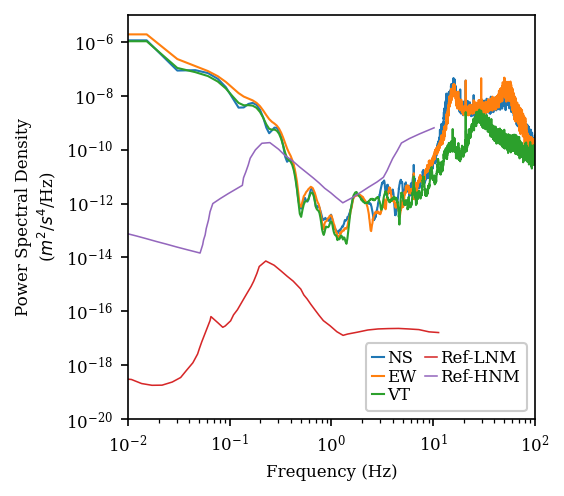

In [82]:
fig, ax = plt.subplots(figsize=(3.5, 3.5), dpi=150)
for component, psd in psds.items():
    ax.plot(psd.frequency, psd.amplitude, label=f"{component.upper()}", lw=1)

if plot_reference_noise_models:
    ax.plot(reference_lnm["Frequency (Hz)"], reference_lnm["PSD (m**2/s**4/Hz)"], label="Ref-LNM")
    ax.plot(reference_hnm["Frequency (Hz)"], reference_hnm["PSD (m**2/s**4/Hz)"], label="Ref-HNM")

ax.legend(loc="upper right")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Power Spectral Density\n" +r"($m^2$/$s^4$/Hz)")
ax.set_xlim(0.01, 100)
ax.set_ylim(1E-20, 1E-5)
ax.legend(loc="lower right", ncol=2)
plt.show()

## Plot PSD in Decibels (dBs)
---

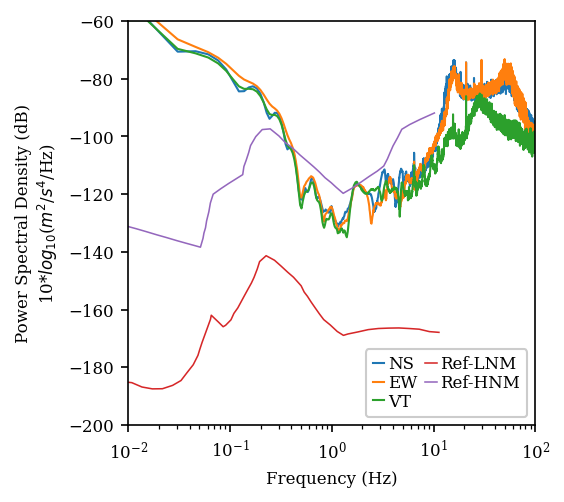

In [83]:
fig, ax = plt.subplots(figsize=(3.5, 3.5), dpi=150)
for component, psd in psds.items():
    ax.plot(psd.frequency, 10*np.log10(psd.amplitude), label=f"{component.upper()}", lw=1)

if plot_reference_noise_models:
    ax.plot(reference_lnm["Frequency (Hz)"], 10*np.log10(reference_lnm["PSD (m**2/s**4/Hz)"]), label="Ref-LNM")
    ax.plot(reference_hnm["Frequency (Hz)"], 10*np.log10(reference_hnm["PSD (m**2/s**4/Hz)"]), label="Ref-HNM")

ax.legend(loc="lower right", ncol=2)
ax.set_xscale("log")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Power Spectral Density (dB)\n" +r"10*$log_{10}$($m^2$/$s^4$/Hz)")
ax.set_xlim(0.01, 100)
ax.set_ylim(-200, -60)
plt.show()